## Generating and testing a hypothesis

Purpose: We want to assess the correlation of structure (e.g. lipophilicity) of some molecules with their inhibitory activity for Acetylcholinesterase (AChE). 

We have already seen that the correlation doesn't seem to be too strong, but is it statistically significant? Hence our hypothesis is still: "High lipohilicity (XlogP) leads to higher potency (pchembl_value)".

Import dependencies and load the combined dataset for assessing our "quantitative structure-activity relationship" (QSAR).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Load both datasets
df = pd.read_csv("ache_qsar_data.csv")
df.head()



,Unnamed: 0,canonical_smiles,pchembl_value,CID,MolecularWeight,XLogP,TPSA,HBondDonorCount,HBondAcceptorCount,RotatableBondCount
0,1,C(=C/C1CCN(Cc2ccccc2)CC1)\c1noc2ccccc12,6.68,9901561,318.4,4.5,29.3,0,3.0,4
1,2,C/C=C1\[C@H]2C=C(C)C[C@]1(NC1OCC3=C4CC(C)(C)C[...,6.96,118715261,492.6,1.2,90.8,4,5.0,2
2,3,C/C=C1\[C@H]2C=C(C)C[C@]1(N[C@H]1OC(=O)C3=C4CC...,5.66,118715260,506.6,1.5,108.0,4,6.0,2
3,4,C=CC(=O)N1C/C(=C\c2ccc(C)cc2)C(=O)/C(=C/c2ccc(...,4.74,24796898,357.4,4.4,37.4,0,2.0,3
4,5,C=CC(=O)N1C/C(=C\c2ccc(Cl)cc2Cl)C(=O)/C(=C/c2c...,4.80,71720637,467.2,6.2,37.4,0,2.0,3


/Applications/anaconda3/envs/DSA101/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


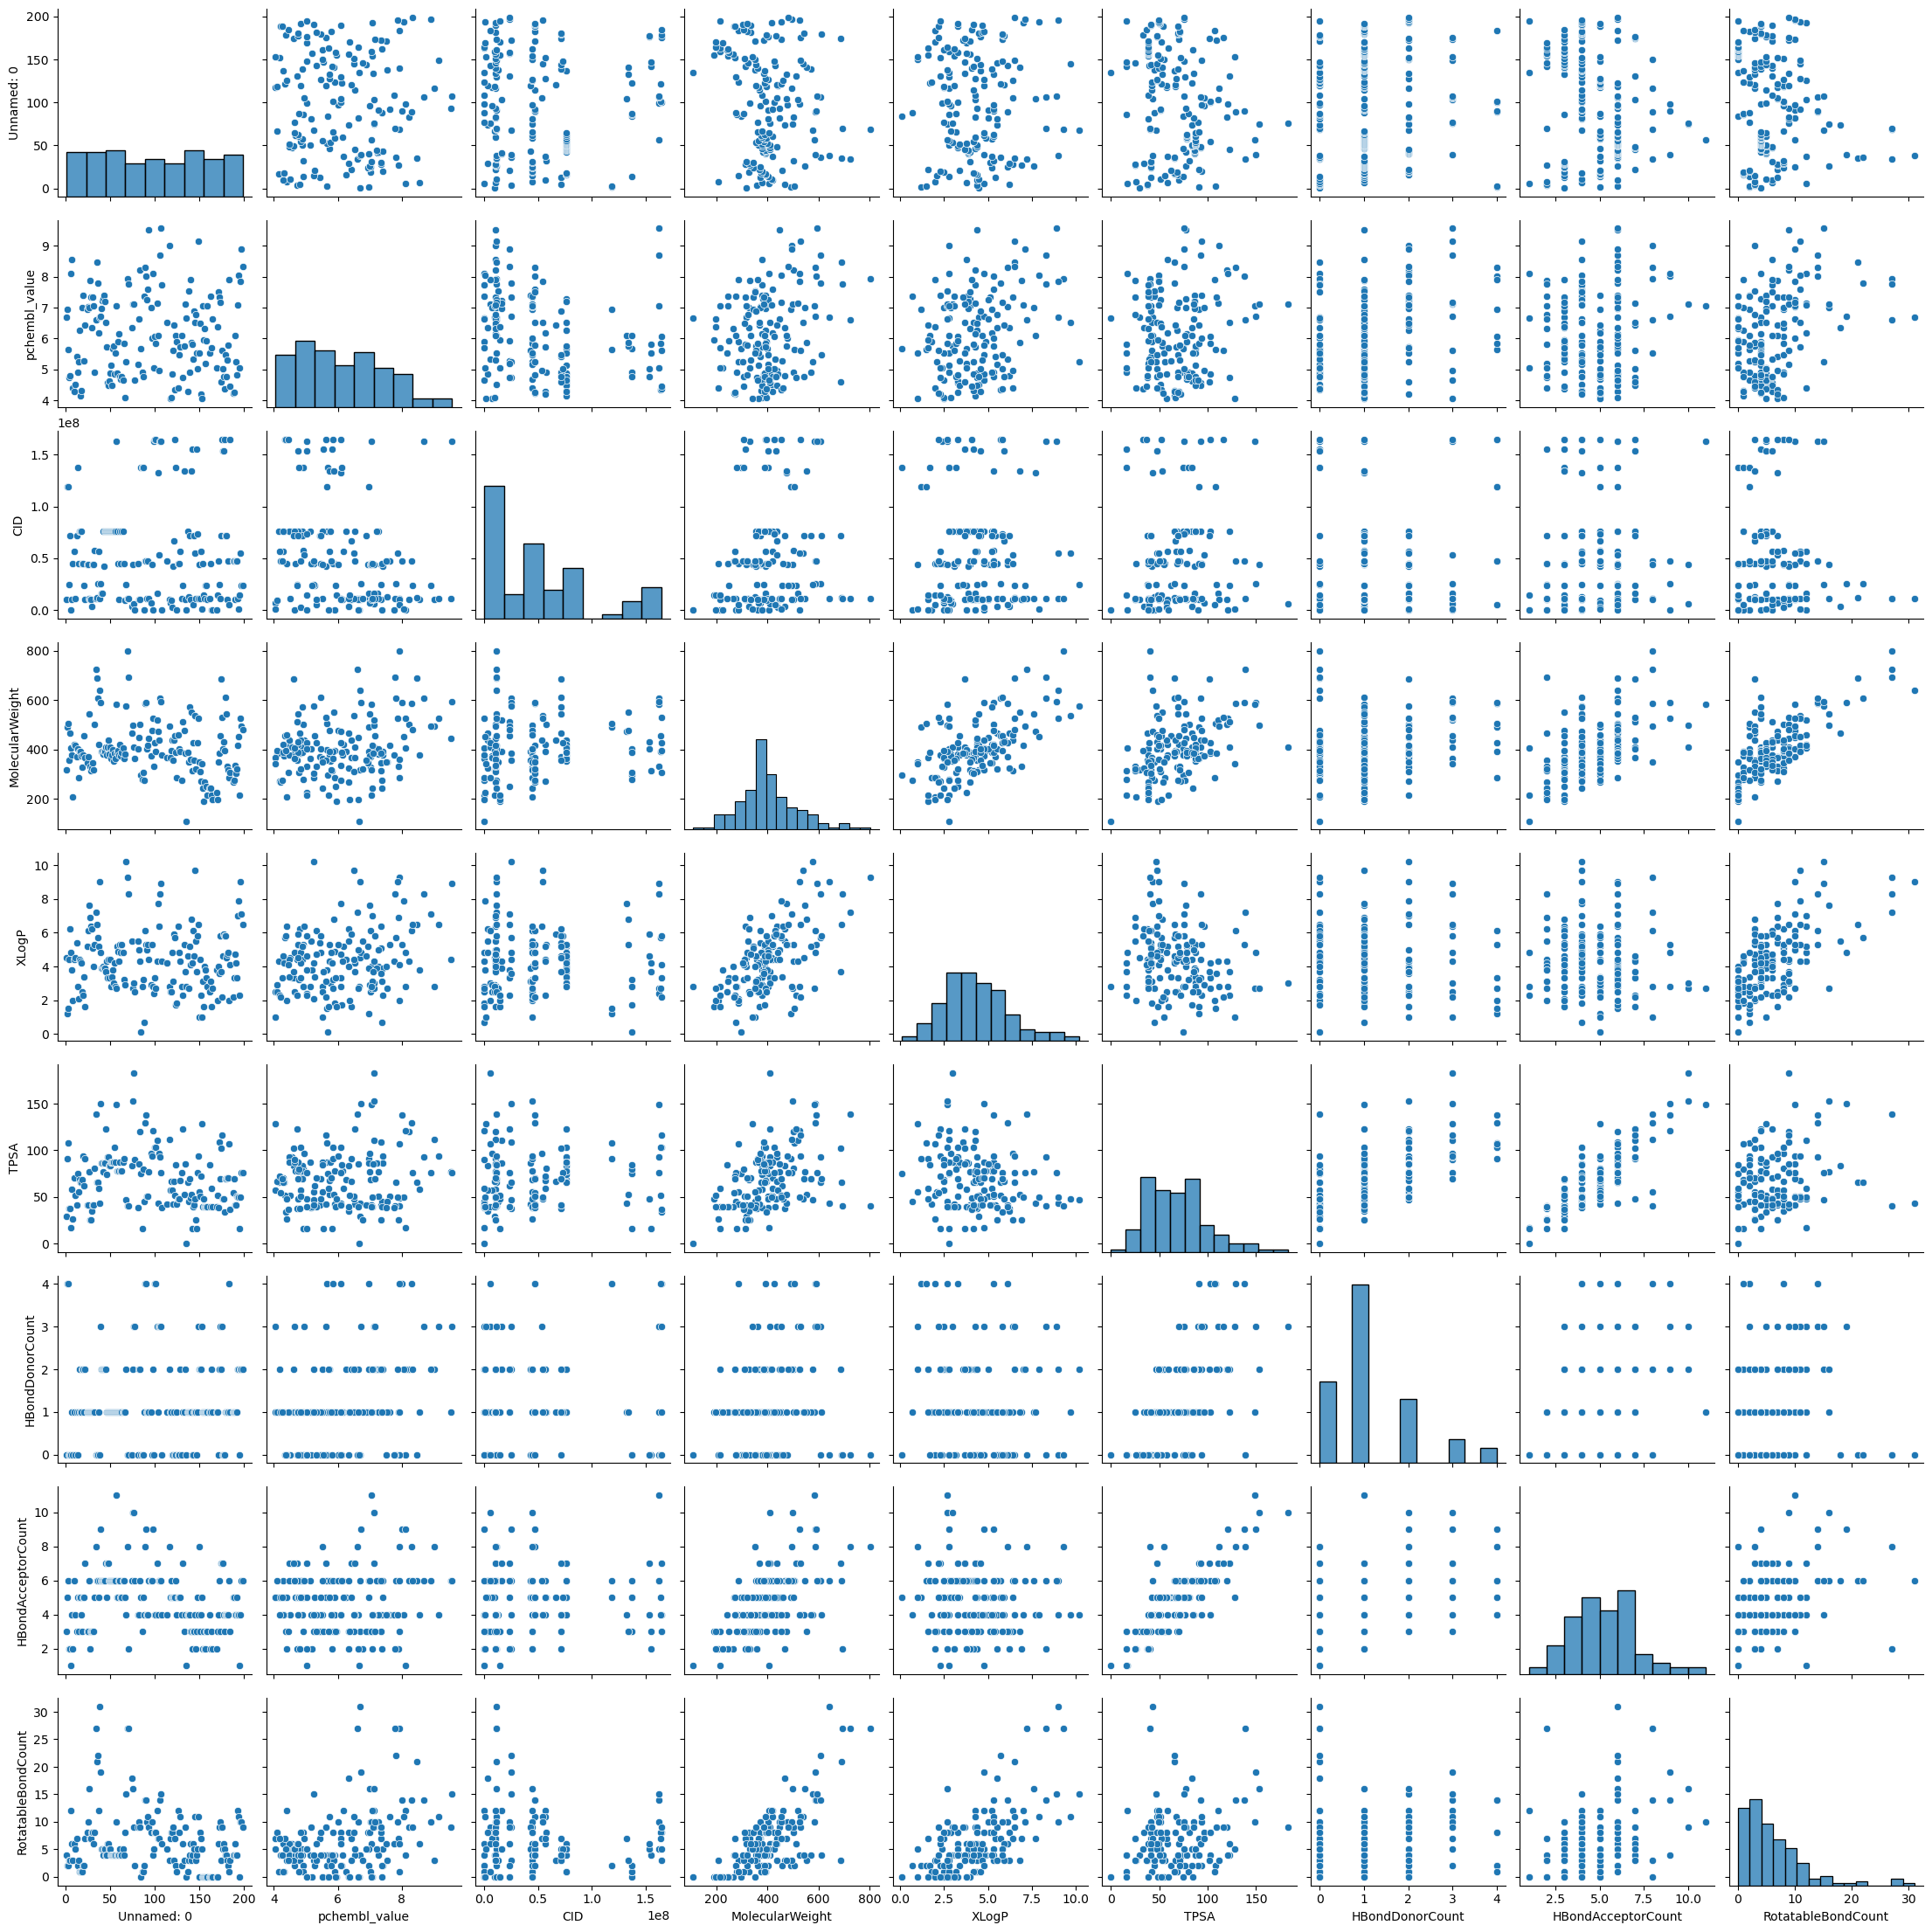

In [5]:
# illustrate all pairwise relationships in the dataset
sns.pairplot(data=df)

Produce a scatterplot of the columns "XLogP" and "pchembl_value".

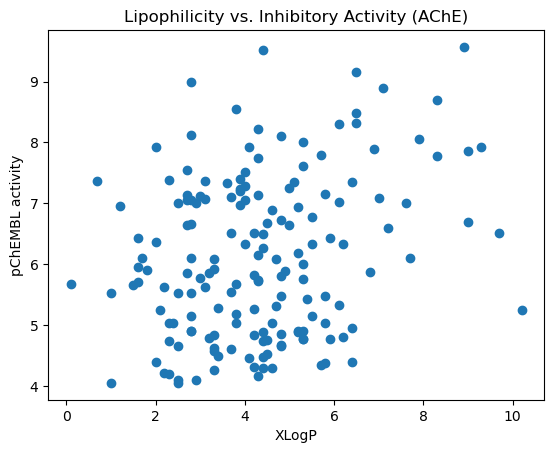

In [3]:
# Quick scatter plot to visualize relationship between XLogP and pchembl_value (Inhibitory activity)
# relevant for the exercise of hypothesis testing
plt.scatter(df["XLogP"], df["pchembl_value"])
plt.xlabel("XLogP")
plt.ylabel("pChEMBL activity")
plt.title("Lipophilicity vs. Inhibitory Activity (AChE)")
plt.show()


To test our hypothesis, we will have a look at highly lipophilic molecules and compare them to the rest. The null-hypothesis is that for both groups, the mean will be the same (mean_low = mean_high).

First, let's create a new column "high_logp" with the condition to XLogP > 3 to start with.

In [4]:
# Define high/low lipophilicity groups
df["high_logp"] = df["XLogP"] > 3
df.head()
# creates a new column 'high_logp' with boolean values

,Unnamed: 0,canonical_smiles,pchembl_value,CID,MolecularWeight,XLogP,TPSA,HBondDonorCount,HBondAcceptorCount,RotatableBondCount,high_logp
0,1,C(=C/C1CCN(Cc2ccccc2)CC1)\c1noc2ccccc12,6.68,9901561,318.4,4.5,29.3,0,3.0,4,True
1,2,C/C=C1\[C@H]2C=C(C)C[C@]1(NC1OCC3=C4CC(C)(C)C[...,6.96,118715261,492.6,1.2,90.8,4,5.0,2,False
2,3,C/C=C1\[C@H]2C=C(C)C[C@]1(N[C@H]1OC(=O)C3=C4CC...,5.66,118715260,506.6,1.5,108.0,4,6.0,2,False
3,4,C=CC(=O)N1C/C(=C\c2ccc(C)cc2)C(=O)/C(=C/c2ccc(...,4.74,24796898,357.4,4.4,37.4,0,2.0,3,True
4,5,C=CC(=O)N1C/C(=C\c2ccc(Cl)cc2Cl)C(=O)/C(=C/c2c...,4.80,71720637,467.2,6.2,37.4,0,2.0,3,True


Now, calculate the means for all low_logp and high_logp molecules. For this, use the "high_logp" column to create two groups. Compare their size and their variance.

In [5]:
# extract the values of the pchembl_value column for both groups
group_high = df[df["high_logp"] == True]["pchembl_value"]
group_low = df[df["high_logp"] == False]["pchembl_value"]
# also following works for group_low:
# group_low = df[~df["high_logp"] == True]["pchembl_value"]
# of even leave the '== True' out entirely

# print(group_high)

# assumption of a t-test is that the two groups have similar sizes
# with logP threshold of 3, the sizes are 120 to 45, so quite unbalanced
print("size high:", group_high.size)
print("size low:", group_low.size)

mean_high = group_high.mean()
mean_low = group_low.mean()
print("mean high:", mean_high)
print("mean low:", mean_low)

# assumption of a t-test is that the variances of the two groups are equal
# variances are somewhat similar
var_high = group_high.var()
var_low = group_low.var()
print("variance high:", var_high)
print("variance low:", var_low)

size high: 120
size low: 45
mean high: 6.208875000000001
mean low: 5.9220000000000015
variance high: 1.8307447321428578
variance low: 1.501353863636364


Now, run a two-sample t-test to assess our null-hypothesis ("the means of the two groups are equal"). If the p_value is lower than 0.05, we can reject the null-hypothesis and our alternative hypothesis is true, i.e. there is a significant difference between the two means (which tells us that the higher lipophilicity leads to increased activity).

In [6]:
# t-test with scipy.stats
# nan_policy treats any NaN values in the data
# 'omit' ignores them

t_value, p_value = stats.ttest_ind(group_high, group_low, equal_var=False, nan_policy="omit")
print(f"t_value = {t_value:.2f}, p_value = {p_value:.4f}")
print(f"{'Reject' if p_value < 0.05 else 'Do not reject'} the null hypothesis.")

t_value = 1.30, p_value = 0.1967
Do not reject the null hypothesis.


In [7]:
# p_value = 0.1967 > 0.05 means we cannot reject the null hypothesis
# Thus with logP threshold of 3, there is no significant difference in inhibitory activity

# Try with a different logP of 5

# Define high/low lipophilicity groups
df["high_logp"] = df["XLogP"] > 5
group_high = df[df["high_logp"] == True]["pchembl_value"]
group_low = df[df["high_logp"] == False]["pchembl_value"]

# with logP threshold of 5, the sizes are 51 to 114, so quite unbalanced
print("size high:", group_high.size)
print("size low:", group_low.size)

mean_high = group_high.mean()
mean_low = group_low.mean()
print("mean high:", mean_high)
print("mean low:", mean_low)

# assumption of a t-test is that the variances of the two groups are equal
# variances are not really similar
var_high = group_high.var()
var_low = group_low.var()
print("variance high:", var_high)
print("variance low:", var_low)

# t-test
t_value, p_value = stats.ttest_ind(group_high, group_low, equal_var=False, nan_policy="omit")
print(f"t_value = {t_value:.2f}, p_value = {p_value:.4f}")
print(f"{'Reject' if p_value < 0.05 else 'Do not reject'} the null hypothesis.")

size high: 51
size low: 114
mean high: 6.536960784313724
mean low: 5.948859649122808
variance high: 2.034137078431373
variance low: 1.5284756792423537
t_value = 2.55, p_value = 0.0126
Reject the null hypothesis.
